# Feature Selection

This notebook browsers the ## features retained during murging and transformation and decides which should be kept for the modeling process.

### Import Data

In [41]:
import psycopg2
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
import matplotlib
import warnings
import yellowbrick as yb
from sklearn.preprocessing import LabelEncoder
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
conn = psycopg2.connect( 
                        host = 'project.cgxhdwn5zb5t.us-east-1.rds.amazonaws.com',
                        port = 5432, 
                        user = 'postgres',
                        password = 'Admin123',
                        database = 'postgres')
cursor = conn.cursor()

In [5]:
DEC2FLOAT = psycopg2.extensions.new_type(
    psycopg2.extensions.DECIMAL.values,
    'DEC2FLOAT',
    lambda value, curs: float(value) if value is not None else None)
psycopg2.extensions.register_type(DEC2FLOAT)

In [6]:
cursor.execute('Select * from "AHS_Household_Class"')
rows = cursor.fetchall()
col_names = []
for elt in cursor.description:
    col_names.append(elt[0])

df = pd.DataFrame(data=rows, columns=col_names )

In [61]:
path = os.path.join(os.getcwd(), 'data', 'working')
df = pd.read_csv(os.path.join(path, 'AHS Household Class.csv'))
df.shape

(28804, 255)

Drop unwanted variales from feature selection

In [62]:
cols = ['Unnamed: 0','CONTROL','YEAR']
droplist = [i for i in df.columns if i in cols]
df.drop(droplist, axis=1, inplace=True)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28804 entries, 0 to 28803
Columns: 252 entries, RATINGHS to FIRSTHOME
dtypes: float64(58), int64(191), object(3)
memory usage: 55.4+ MB


In [64]:
df.describe()

,TOTROOMS,PERPOVLVL,DINING,LAUNDY,STORIES,MONLSTOCC,HHAGE,HHMOVE,HHINUSYR,PARTNER,...,HHWALK,HHCARE,HHERRND,DISHH,MVG1LOC,MVG2LOC,MVG3LOC,MOVFORCE,SPLITSAMP,FIRSTHOME
count,28804.000000,28804.000000,28804.000000,28804.000000,28804.000000,28804.0,28804.000000,28804.000000,28804.000000,28804.000000,...,28804.000000,28804.000000,28804.000000,28804.000000,28804.000000,28804.000000,28804.000000,28804.000000,28804.000000,28804.0
mean,6.096098,333.158867,0.574955,0.327593,1.890605,-6.0,51.607902,1997.817317,408.758888,0.144667,...,1.775795,1.829642,1.810721,1.641786,-4.880156,-5.906575,-5.991911,-5.163901,1.502639,1.0
std,1.407323,160.315828,0.530864,0.496868,0.981626,0.0,15.630453,15.821989,809.732017,0.654548,...,1.302975,1.291882,1.300974,1.347149,2.836874,0.864487,0.258126,2.472269,0.500002,0.0
min,1.000000,1.000000,0.000000,0.000000,1.000000,-6.0,15.000000,1930.000000,-6.000000,0.000000,...,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,1.000000,1.0
25%,5.000000,197.000000,0.000000,0.000000,1.000000,-6.0,39.000000,1989.000000,-6.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,-6.000000,-6.000000,-6.000000,-6.000000,1.000000,1.0
50%,6.000000,357.000000,1.000000,0.000000,2.000000,-6.0,51.000000,2002.000000,-6.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,-6.000000,-6.000000,-6.000000,-6.000000,2.000000,1.0
75%,7.000000,501.000000,1.000000,1.000000,3.000000,-6.0,63.000000,2010.000000,-6.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,-6.000000,-6.000000,-6.000000,-6.000000,2.000000,1.0
max,13.000000,501.000000,2.000000,2.000000,7.000000,-6.0,85.000000,2017.000000,2016.000000,4.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.0


In [65]:
# Change the data type to int32
df.drop(['RATINGHS','HINCP','FINCP'], axis=1).astype('int32')

,TOTROOMS,PERPOVLVL,DINING,LAUNDY,STORIES,MONLSTOCC,HHAGE,HHMOVE,HHINUSYR,PARTNER,...,HHWALK,HHCARE,HHERRND,DISHH,MVG1LOC,MVG2LOC,MVG3LOC,MOVFORCE,SPLITSAMP,FIRSTHOME
0,5,361,0,1,1,-6,64,1990,-6,0,...,2,2,2,2,2,-6,-6,-6,2,1
1,6,501,1,0,3,-6,38,2015,-6,0,...,2,2,2,2,-6,-6,-6,-6,2,1
2,7,501,1,0,3,-6,43,2016,-6,3,...,2,2,2,2,2,-6,-6,2,2,1
3,7,501,1,0,3,-6,52,2004,-6,0,...,2,2,2,2,-6,-6,-6,-6,1,1
4,5,52,0,0,1,-6,37,2000,1996,0,...,2,2,2,2,-6,-6,-6,-6,2,1
5,7,406,1,1,3,-6,47,2008,2003,0,...,2,2,2,2,-6,-6,-6,-6,2,1
6,6,113,0,0,2,-6,65,1965,-6,0,...,2,2,2,2,-6,-6,-6,-6,1,1
7,4,501,0,0,7,-6,49,2000,-6,0,...,2,2,2,2,-6,-6,-6,-6,2,1
8,4,104,0,0,1,-6,41,2006,1997,0,...,2,2,2,2,-6,-6,-6,-6,1,1
9,4,117,0,0,1,-6,38,2001,-6,0,...,2,2,2,2,-6,-6,-6,-6,2,1


## Feature Analysis


In [66]:
# Extract our X and y data
X = df.drop('RATINGHS', axis=1)
y = df['RATINGHS']

### Encode our target variable

In [67]:
# Encode our target variable
encoder = LabelEncoder().fit(y)
y = encoder.transform(y)

encoder = LabelEncoder().fit(X['HINCP'])
X['HINCP'] = encoder.transform(X['HINCP'])

encoder = LabelEncoder().fit(X['FINCP'])
X['FINCP'] = encoder.transform(X['FINCP'])

# Correlation Threshold

In [74]:
pd.set_option('max_rows', 500)
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

In [75]:
X.drop(X[to_drop], axis=1, inplace=True)
X.shape

(28804, 165)

In [70]:
pd.set_option('max_rows', 5000)
df.corr().abs().where(np.triu(np.ones(df.corr().abs().shape), k=1).astype(np.bool)).unstack().sort_values(ascending=False)

BEDROOMS    TOTROOMS      0.779749
LEAKOROOF   LEAKO         0.778611
HSHLDTYPE   HHMAR         0.770501
ENTRYSYS    BLD           0.769832
SEARCHSTOP  MVG1PER       0.769808
FOUNDTYPE   BLD           0.753128
NEARABAND   NUMHEAR       0.749813
HHMOVE      HHAGE         0.744454
CONDO       LOTSIZE       0.741653
NUMPEOPLE   NUMADULTS     0.738687
NHQRISK     NUMHEAR       0.726385
NEARABAND   NHQRISK       0.725633
NEARBARCL   NEARABAND     0.717275
ENTRYSYS    FOUNDTYPE     0.708620
LEAKIPLUM   LEAKI         0.705779
BLD         LOTSIZE       0.699901
COLDUTIL    COLDEQ        0.696401
NHQRISK     NHQPCRIME     0.693738
HHADLTKIDS  NUMADULTS     0.685067
WASHER      DRYER         0.681610
FINROOMS    TOTROOMS      0.677133
CONDO       BLD           0.675663
NUMELDERS   HHAGE         0.674930
UPKEEP      ADEQUACY      0.669951
NEARABAND   NHQPCRIME     0.665766
HHRACEAS    HHRACE        0.661319
NHQPCRIME   NUMHEAR       0.647228
ENTRYSYS    UNITFLOORS    0.637099
NEARBARCL   NUMHEAR 

## Feature Importance

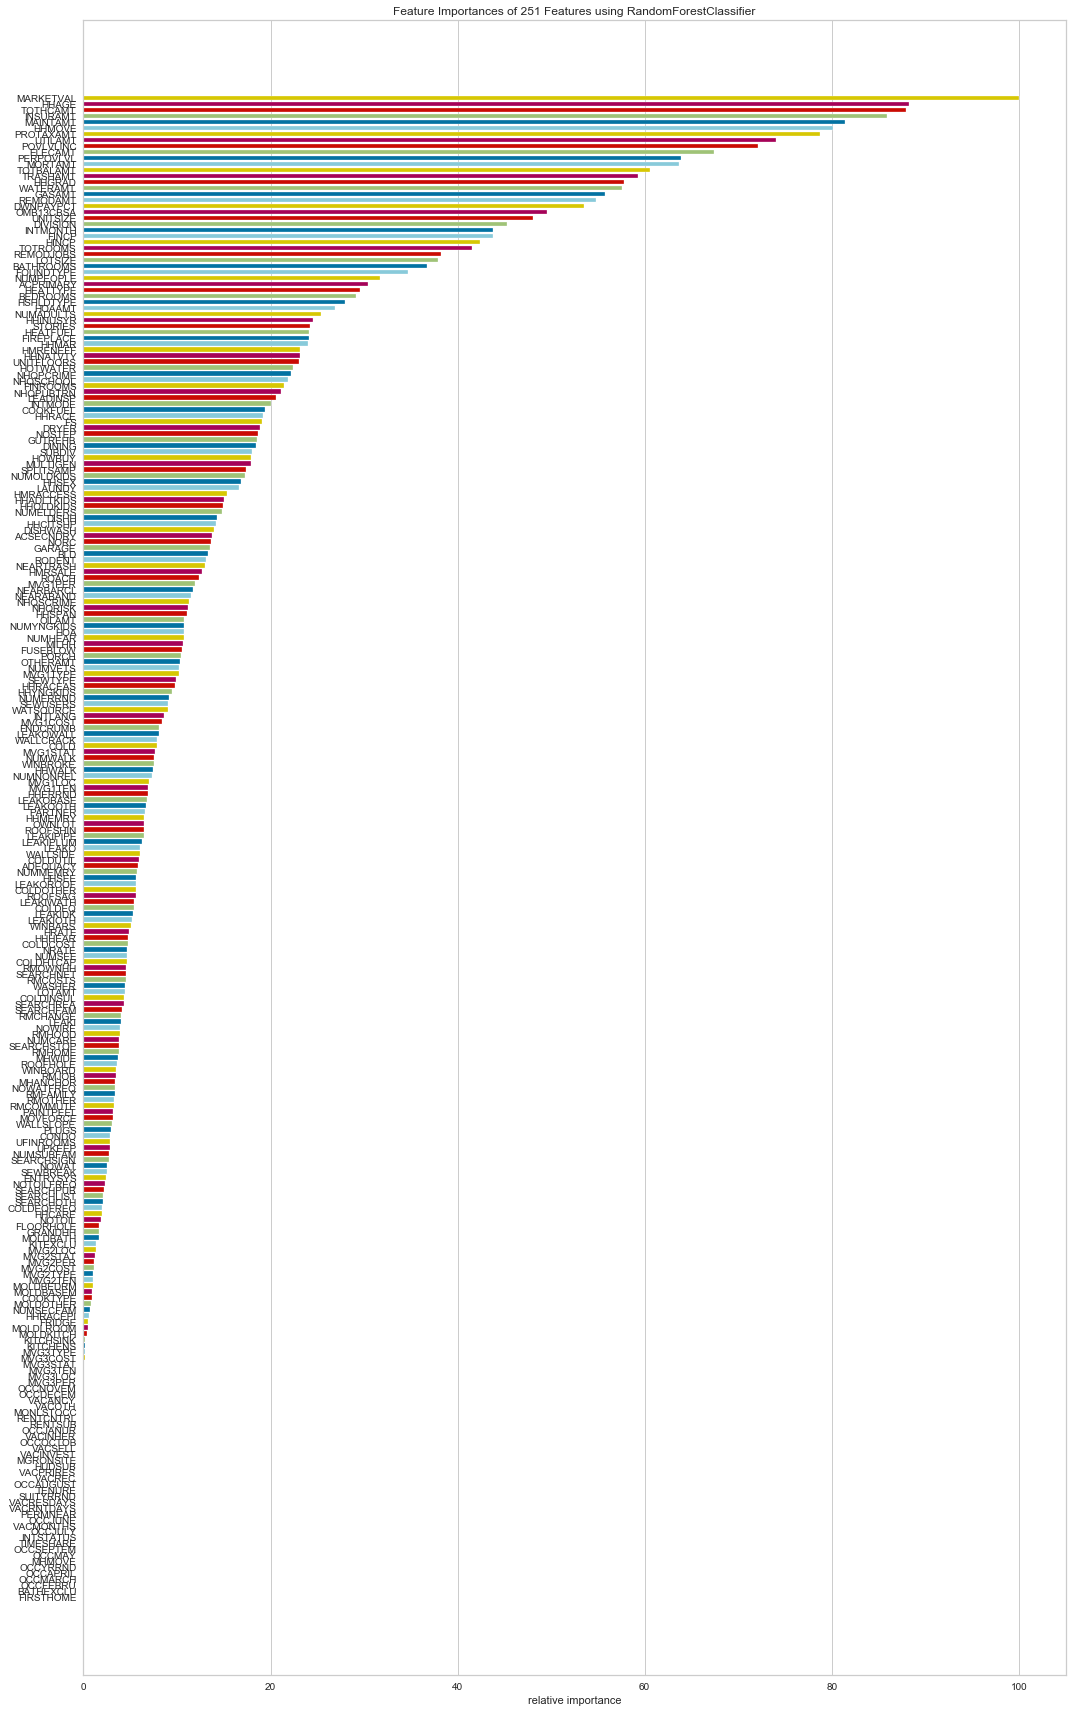

In [35]:
#Using Randomforest classifier
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model, size=(1080, 1720))

viz.fit(X, y)
viz.show()

In [36]:
# Create a dictionary that will map the feature name with its feature importance
feats = {}

# Loop through Feature
for feature, importance in zip(X.columns, model.feature_importances_):
    feats[feature] = importance # Add the name/value pair

# View our dictionary, but sorted in order of importance
sorted(feats.items(), key=lambda x: x[1], reverse=True)

[('MARKETVAL', 0.028850263460629293),
 ('HHAGE', 0.025476904963723856),
 ('TOTHCAMT', 0.025373233612279732),
 ('INSURAMT', 0.024770695926544087),
 ('MAINTAMT', 0.023485350265850184),
 ('HHMOVE', 0.023110469574813258),
 ('PROTAXAMT', 0.02271375356035788),
 ('UTILAMT', 0.02135967661819952),
 ('POVLVLINC', 0.02081960672894164),
 ('ELECAMT', 0.01945580569608601),
 ('PERPOVLVL', 0.01843161347994744),
 ('MORTAMT', 0.01835413754949428),
 ('TOTBALAMT', 0.017477845868695937),
 ('TRASHAMT', 0.01711698253060153),
 ('HHGRAD', 0.016669673218503447),
 ('WATERAMT', 0.016622412941233997),
 ('GASAMT', 0.016097464927869932),
 ('REMODAMT', 0.015800070528719894),
 ('DWNPAYPCT', 0.015430846894189703),
 ('OMB13CBSA', 0.014294817865526282),
 ('UNITSIZE', 0.013865405521100858),
 ('DIVISION', 0.013067552143636224),
 ('INTMONTH', 0.01264039702814367),
 ('FINCP', 0.012629991983422243),
 ('HINCP', 0.012245598126126475),
 ('TOTROOMS', 0.011973606236818528),
 ('REMODJOBS', 0.011035927699824675),
 ('LOTSIZE', 0.0109

C:\Users\Michael\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Michael\Anaconda3\lib\site-packages\yellowbrick\model_selection\importances.py:195: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


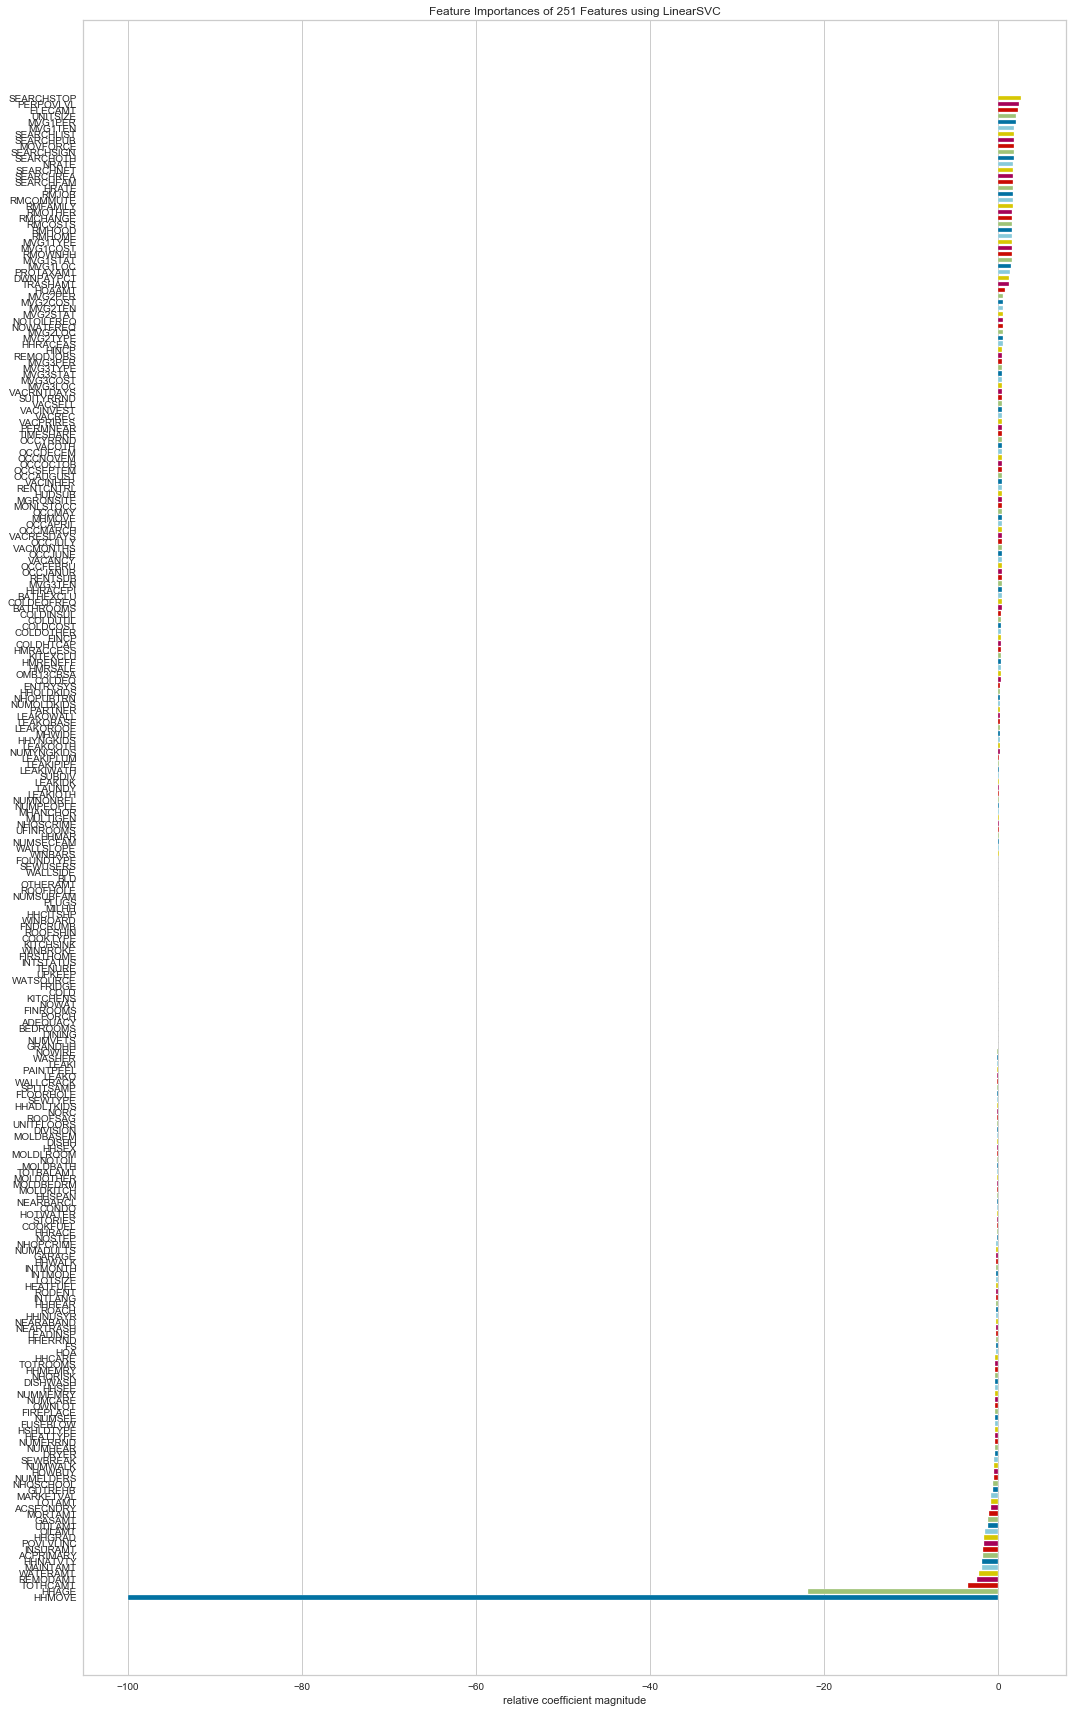

In [37]:
# Using LinearSVC model
from sklearn import svm
from yellowbrick.features import FeatureImportances

model = svm.LinearSVC()
viz = FeatureImportances(model, size=(1080, 1720))

viz.fit(X, y)
viz.show()

C:\Users\Michael\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Michael\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


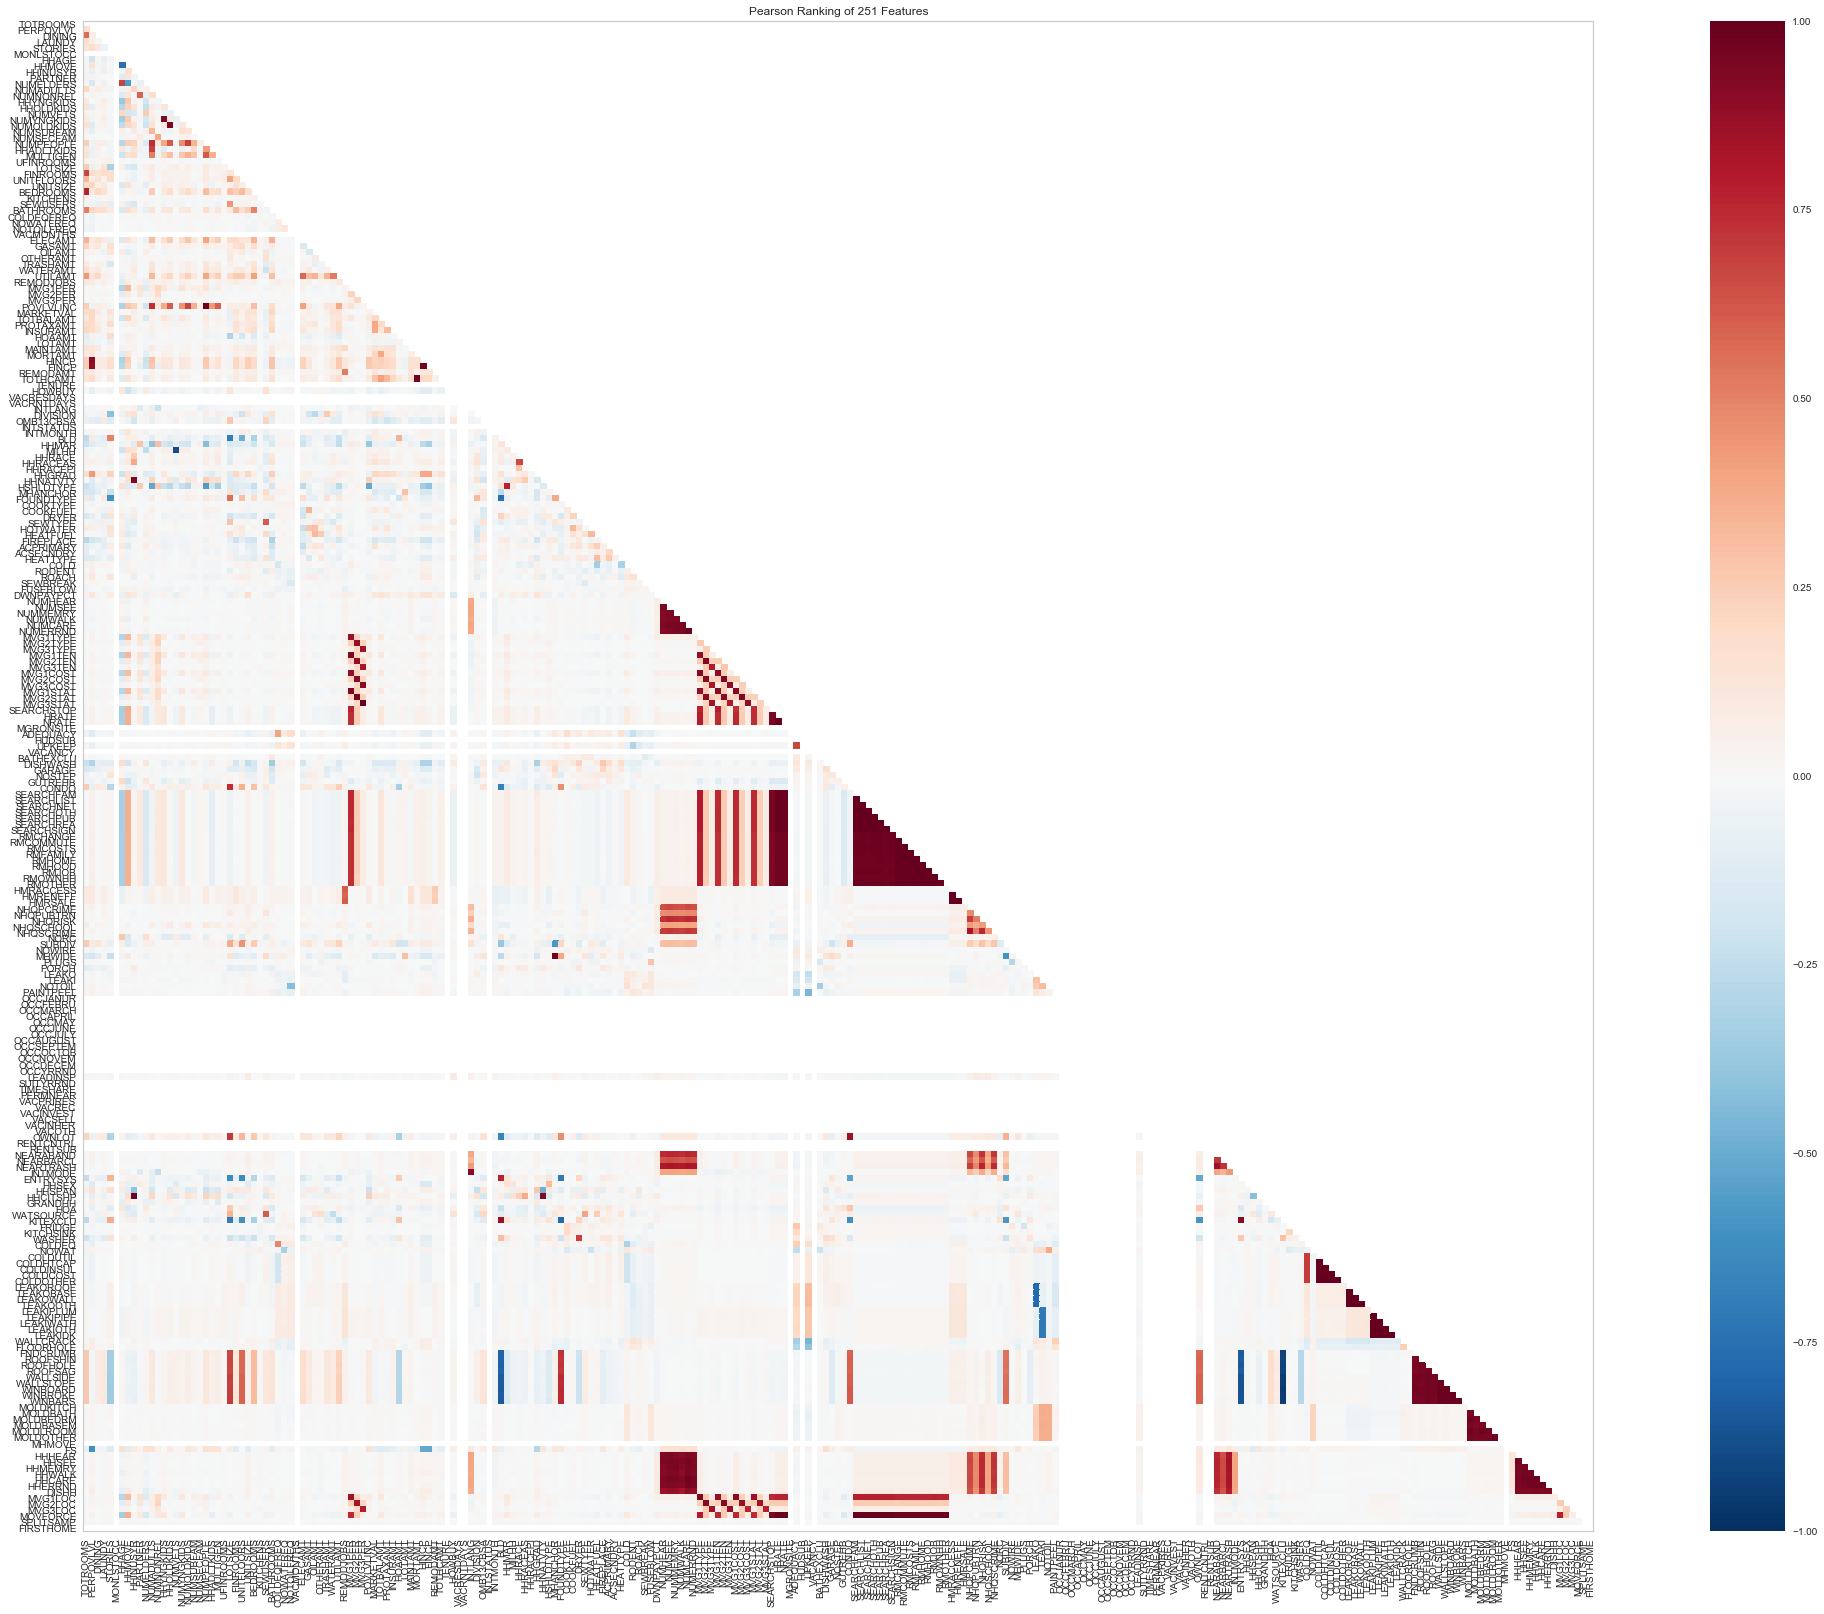

In [38]:
from yellowbrick.features import Rank2D

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', size=(3000, 2000))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

## Feature Selection

In [42]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [78]:
features = y
labels   = X
selected_features=[]

In [79]:
model = Lasso()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
selected_features = list(features.iloc[:, sfm.get_support(indices=True)])
print(list(features.iloc[:, sfm.get_support(indices=True)]))

ValueError: Expected 2D array, got 1D array instead:
array=[0. 2. 3. ... 0. 2. 3.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [45]:
model = Ridge()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
selected_features.extend(list(features.iloc[:, sfm.get_support(indices=True)]))
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['TOTROOMS', 'DINING', 'LAUNDY', 'STORIES', 'NUMELDERS', 'NUMYNGKIDS', 'NUMSUBFAM', 'NUMSECFAM', 'NUMPEOPLE', 'LOTSIZE', 'FINROOMS', 'BEDROOMS', 'KITCHENS', 'COLDEQFREQ', 'MVG3PER', 'HHGRAD', 'RODENT', 'NUMWALK', 'MVG3TYPE', 'MVG3TEN', 'MVG3STAT', 'HRATE', 'NRATE', 'ADEQUACY', 'UPKEEP', 'BATHEXCLU', 'SEARCHFAM', 'SEARCHLIST', 'SEARCHOTH', 'SEARCHREA', 'RMCHANGE', 'RMCOMMUTE', 'RMCOSTS', 'RMFAMILY', 'RMHOME', 'RMHOOD', 'RMOWNHH', 'HMRENEFF', 'NHQSCRIME', 'NOWIRE', 'PLUGS', 'LEAKO', 'LEAKI', 'NEARTRASH', 'HHSEX', 'HHSPAN', 'HHCITSHP', 'GRANDHH', 'WATSOURCE', 'KITEXCLU', 'FRIDGE', 'WASHER', 'COLDEQ', 'COLDUTIL', 'COLDHTCAP', 'COLDINSUL', 'COLDOTHER', 'LEAKOWALL', 'LEAKOOTH', 'LEAKIPLUM', 'LEAKIPIPE', 'LEAKIOTH', 'WALLCRACK', 'ROOFHOLE', 'WINBOARD', 'WINBROKE', 'MOLDKITCH', 'MOLDBATH', 'MOLDBEDRM', 'MOLDBASEM', 'MOLDLROOM', 'MOLDOTHER', 'HHWALK', 'HHCARE', 'HHERRND', 'MVG3LOC', 'MOVFORCE']


In [46]:
model = ElasticNet()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
selected_features.extend(features.iloc[:, sfm.get_support(indices=True)])
selected_features = list(set(selected_features))
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['PERPOVLVL', 'HHAGE', 'HHMOVE', 'HHINUSYR', 'ELECAMT', 'INSURAMT', 'HOAAMT', 'HHNATVTY']


In [47]:
print(list(set(selected_features)))

['MOVFORCE', 'GRANDHH', 'RMCOMMUTE', 'ROOFHOLE', 'HHERRND', 'MAINTAMT', 'MOLDBASEM', 'HHAGE', 'COLDEQ', 'KITCHENS', 'COLDUTIL', 'NEARTRASH', 'UTILAMT', 'RMHOME', 'MVG3TYPE', 'HHSEX', 'LEAKIPIPE', 'LAUNDY', 'SEARCHREA', 'NUMELDERS', 'LOTSIZE', 'RMOWNHH', 'NUMWALK', 'SEARCHOTH', 'NUMPEOPLE', 'HHINUSYR', 'TOTROOMS', 'INSURAMT', 'NHQSCRIME', 'NUMSUBFAM', 'WATSOURCE', 'MOLDOTHER', 'MOLDKITCH', 'MVG3PER', 'COLDINSUL', 'LEAKI', 'RMFAMILY', 'HOAAMT', 'HHSPAN', 'FRIDGE', 'LEAKIOTH', 'HHWALK', 'SEARCHFAM', 'NOWIRE', 'COLDEQFREQ', 'ELECAMT', 'SEARCHLIST', 'HHMOVE', 'PLUGS', 'BATHEXCLU', 'LEAKOWALL', 'MOLDLROOM', 'WASHER', 'BEDROOMS', 'WALLCRACK', 'MORTAMT', 'HHGRAD', 'COLDHTCAP', 'HHNATVTY', 'MOLDBEDRM', 'RMHOOD', 'MVG3STAT', 'COLDOTHER', 'MVG3LOC', 'LEAKO', 'NRATE', 'HMRENEFF', 'PERPOVLVL', 'WINBOARD', 'RMCHANGE', 'HHCITSHP', 'RMCOSTS', 'HRATE', 'ADEQUACY', 'UPKEEP', 'WINBROKE', 'LEAKOOTH', 'MOLDBATH', 'NUMSECFAM', 'RODENT', 'MVG3TEN', 'NUMYNGKIDS', 'STORIES', 'DINING', 'FINROOMS', 'LEAKIPLUM', 

In [48]:
df[['RATINGHS'] + selected_features].to_csv(os.path.join(path, 'AHS Household Class Features Selected.csv'))

KeyError: "['NHQSCRIME', 'MVG3LOC', 'NRATE', 'HMRENEFF', 'MOLDOTHER', 'MOVFORCE', 'WINBOARD', 'RMCOMMUTE', 'ROOFHOLE', 'RMCHANGE', 'HHCITSHP', 'RMCOSTS', 'HHERRND', 'HRATE', 'WINBROKE', 'COLDOTHER', 'MOLDBASEM', 'COLDINSUL', 'LEAKOOTH', 'MOLDBATH', 'RMFAMILY', 'LEAKOWALL', 'MOLDLROOM', 'NEARTRASH', 'MVG3TEN', 'RMHOME', 'NUMYNGKIDS', 'MVG3TYPE', 'LEAKIOTH', 'LEAKIPIPE', 'HHWALK', 'COLDHTCAP', 'SEARCHREA', 'RMOWNHH', 'HHNATVTY', 'MOLDBEDRM', 'KITEXCLU', 'NUMWALK', 'RMHOOD', 'SEARCHOTH', 'SEARCHFAM', 'SEARCHLIST', 'HHCARE', 'MVG3STAT'] not in index"

In [80]:
df.shape

(28804, 166)